In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from alpha_vantage.timeseries import TimeSeries
import os

In [97]:
TIME_SERIES = TimeSeries(key=os.environ.get("ALPHA_VANTAGE_KEY"), output_format="pandas", indexing_type="data")
COLUMN_RENAME = {"date": "Date", "1. open": "Open", "2. high": "High", "3. low": "Low", "4. close": "Close", "5. adjusted close": "Adj Close", "6. volume": "Volume"}

In [98]:
TICKER = "CEI"
TICKER

'CEI'

In [99]:
dailyAdjustedRaw = TIME_SERIES.get_daily_adjusted(symbol=TICKER, outputsize="full")[0]
df = dailyAdjustedRaw.sort_values(by="date", ascending=False).reset_index().rename(columns=COLUMN_RENAME).drop(["7. dividend amount", "8. split coefficient"], axis=1, inplace=False)

In [106]:
df = df.head(90).sort_values(by="Date", ascending=True).reset_index().drop(["index"], axis=1, inplace=False)
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
85,2021-09-27,2.26,2.80,2.21,2.72,2.72,353965115.0
86,2021-09-28,2.88,3.44,2.62,3.22,3.22,761080418.0
87,2021-09-29,3.06,4.85,2.89,3.42,3.42,988353227.0
88,2021-09-30,4.13,4.37,3.44,3.82,3.82,460059396.0
89,2021-10-01,3.49,3.54,2.86,3.25,3.25,323930920.0


In [101]:
# df = pd.read_csv('../dataset/GOOG-year.csv')
# df.head()

In [102]:
short_window = int(0.025 * len(df))
long_window = int(0.05 * len(df))

signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0

signals['short_ma'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_ma'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:] 
                                            > signals['long_ma'][short_window:], 1.0, 0.0)   
signals['positions'] = signals['signal'].diff()

signals

,signal,short_ma,long_ma,positions
0,0.0,0.60870,0.608700,NaN
1,0.0,0.63435,0.634350,0.0
2,1.0,0.64990,0.636167,1.0
3,1.0,0.66450,0.649425,0.0
4,1.0,0.67945,0.664675,0.0
...,...,...,...,...
85,1.0,2.38000,2.030000,0.0
86,1.0,2.97000,2.470000,0.0
87,1.0,3.32000,2.850000,0.0
88,1.0,3.62000,3.295000,0.0


In [103]:
def buy_stock(
    real_movement,
    signal,
    df,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'Date: %s day %d: total balances %f, not enough money to buy a unit price %f'
                % (df.Date[i], i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'Date: %s day %d: buy %d units at price %f, total balance %f'
                % (df.Date[i], i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('Date: %s day %d: cannot sell anything, inventory 0' % (df.Date[i], i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'Date: %s day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (df.Date[i], i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [104]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['positions'], df, initial_money=1000, max_buy=1000, max_sell=1000)

Date: 2021-05-28 00:00:00 day 2: buy 1000 units at price 639.800000, total balance 360.200000
Date: 2021-06-04 00:00:00 day 6, sell 1000 units at price 670.100000, investment 4.735855 %, total balance 1030.300000,
Date: 2021-06-07 00:00:00 day 7: buy 1000 units at price 680.000000, total balance 350.300000
Date: 2021-06-10 00:00:00 day 10, sell 1000 units at price 669.800000, investment -1.500000 %, total balance 1020.100000,
Date: 2021-06-15 00:00:00 day 13: buy 1000 units at price 689.700000, total balance 330.400000
Date: 2021-06-18 00:00:00 day 16, sell 1000 units at price 643.300000, investment -6.727563 %, total balance 973.700000,
Date: 2021-06-22 00:00:00 day 18: buy 1000 units at price 668.800000, total balance 304.900000
Date: 2021-06-28 00:00:00 day 22, sell 1000 units at price 651.000000, investment -2.661483 %, total balance 955.900000,
Date: 2021-07-01 00:00:00 day 25: buy 1000 units at price 767.600000, total balance 188.300000
Date: 2021-07-06 00:00:00 day 27, sell 1000

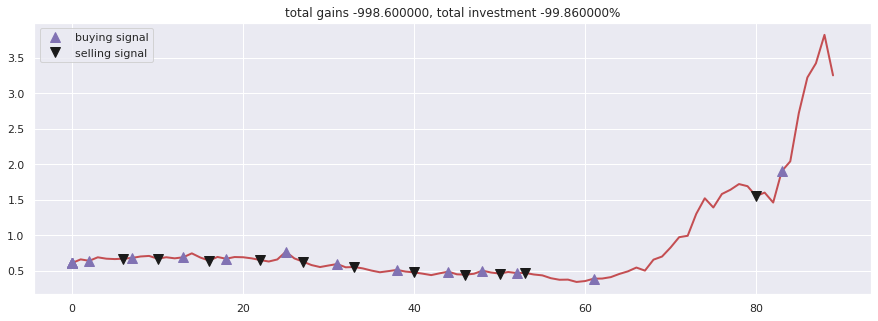

In [105]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()